In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import difflib
import time
import config
import spotipy
import json
from sklearn.preprocessing import StandardScaler
import requests  #don't know if its necessary
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from IPython.display import IFrame
import random
import itertools 
import difflib
import warnings
warnings.filterwarnings("ignore")

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config

#Initialize SpotiPy with user credentials IMPORT FROM CONFIG.PY
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [3]:
AUTH_URL = 'https://accounts.spotify.com/api/token'  #In order to access the various endpoints of the Spotify API, we need to pass an access token.

In [4]:
# POST a request with our client credentials and save the appropriate part of the response
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': config.client_id,
    'client_secret': config.client_secret,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [5]:
access_token

'BQBenQx6P6MeSM2AIdcvdeoUJUqrmRpyRGiCyFtd8x3Qnk5Yat6goJilG2e1gN_ECwPammlk1qh_r-x-0x4'

In [6]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [7]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# CLUSTERING

- We are going to cluster the data based on 9 audio features

## Load data

In [8]:
X = pd.read_csv('features_df.csv')

In [9]:
X.head()

,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_id
0,0,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328,21UPYSRWFKwtqvSAnFnSvS
1,1,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157,0cGUm45nv7Z6M6qdXYQGTX
2,2,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209,4F4pp8NUW08JuXwnoxglpN
3,3,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156,25uiPmTg16RbhZWAqwLBy5
4,4,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417,04WGKyAt0klDPxUw2roFfi


In [10]:
len(X)

307

### Id as index, we need to keep it later

In [11]:
X = X.set_index('artist_id')

In [12]:
X.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [13]:
X = X.drop('Unnamed: 0', axis=1)

In [14]:
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
artist_id,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328
0cGUm45nv7Z6M6qdXYQGTX,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157
4F4pp8NUW08JuXwnoxglpN,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209
25uiPmTg16RbhZWAqwLBy5,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156
04WGKyAt0klDPxUw2roFfi,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417


In [15]:
X.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,307.000000,307.000000,307.000000,307.000000,307.000000,3.070000e+02,307.000000,307.000000,307.000000
mean,0.557961,0.646766,-8.716332,0.091691,0.246630,3.102157e-01,0.194687,0.414843,123.089827
std,0.124100,0.138085,2.685344,0.051495,0.173359,2.687652e-01,0.054004,0.133507,9.279678
min,0.202000,0.223331,-22.982495,0.027527,0.000060,3.472414e-07,0.092550,0.078617,94.863250
25%,0.469736,0.559802,-10.206241,0.056464,0.116162,7.321665e-02,0.161097,0.318228,116.522336
50%,0.569934,0.652483,-8.259528,0.077464,0.203063,2.248886e-01,0.182274,0.419364,123.578000
75%,0.648307,0.749813,-6.843047,0.108357,0.342559,5.343226e-01,0.221296,0.516919,128.619692
max,0.835778,0.951338,-1.869351,0.347774,0.847979,9.111667e-01,0.451535,0.811813,162.251534


## Scaling features

In [16]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [17]:
X_scaled 

array([[ 0.97154735, -0.34648177,  0.3790203 , ..., -0.26047328,
         0.58042304, -0.4329944 ],
       [ 0.02622105, -0.34951999,  0.8671256 , ..., -0.09295005,
         0.330411  , -0.79492997],
       [ 1.3003378 ,  0.42747557,  1.02921274, ..., -0.79238481,
         0.81566889, -1.21286144],
       ...,
       [-2.87301717, -1.21232461, -2.48840561, ..., -1.89437674,
        -2.52253665, -0.84407684],
       [ 0.6539061 ,  1.0695747 ,  0.18498584, ..., -0.24934929,
         0.5470815 ,  1.73168461],
       [-0.51908806,  0.43878565,  0.53231238, ..., -0.27614748,
        -1.11768551,  1.68519058]])

### Create a dataframe with this array, with column and index from the df without scaled

In [18]:
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns, index=X.index)
display(X.head())
print('After scaling:')
display(X_scaled_df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
artist_id,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328
0cGUm45nv7Z6M6qdXYQGTX,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157
4F4pp8NUW08JuXwnoxglpN,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209
25uiPmTg16RbhZWAqwLBy5,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156
04WGKyAt0klDPxUw2roFfi,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417


After scaling:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
artist_id,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0.971547,-0.346482,0.379020,-0.051159,0.551486,-0.825840,-0.260473,0.580423,-0.432994
0cGUm45nv7Z6M6qdXYQGTX,0.026221,-0.349520,0.867126,1.643118,0.397050,-1.122004,-0.092950,0.330411,-0.794930
4F4pp8NUW08JuXwnoxglpN,1.300338,0.427476,1.029213,0.167491,-0.254766,-1.118909,-0.792385,0.815669,-1.212861
25uiPmTg16RbhZWAqwLBy5,0.352991,1.120684,1.588085,-0.024382,-0.921550,-1.037949,0.003844,0.768590,0.307984
04WGKyAt0klDPxUw2roFfi,-0.662191,-2.307410,-1.525973,-0.755500,0.533214,0.227804,-0.836097,-1.618924,-1.065719


## Clustering with K-Means with the scaled df

- We start with 4 clusters, let's see if is a good decision

In [19]:
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=4, random_state=1234)

In [20]:
kmeans.labels_

array([3, 3, 3, 1, 0, 3, 1, 1, 3, 1, 0, 1, 3, 3, 3, 1, 0, 3, 1, 0, 0, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 1, 3, 3, 1, 2, 2, 0, 0, 3, 1, 2, 0, 1, 0, 3, 1, 1, 0, 1,
       3, 2, 3, 0, 0, 1, 0, 0, 1, 3, 0, 1, 3, 2, 0, 1, 1, 1, 3, 1, 3, 3,
       1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 3, 3,
       3, 0, 3, 3, 0, 0, 0, 0, 1, 0, 3, 3, 3, 3, 1, 1, 0, 2, 0, 1, 1, 1,
       0, 0, 1, 3, 0, 3, 1, 1, 1, 0, 0, 0, 2, 2, 3, 2, 2, 0, 3, 3, 2, 2,
       2, 0, 3, 1, 3, 1, 1, 3, 3, 3, 1, 2, 1, 1, 2, 3, 3, 1, 0, 3, 2, 3,
       1, 1, 3, 3, 3, 1, 0, 2, 1, 3, 0, 1, 0, 0, 0, 2, 2, 3, 3, 3, 2, 1,
       1, 2, 2, 1, 2, 1, 3, 0, 3, 1, 0, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 1,
       1, 0, 3, 3, 1, 0, 3, 1, 1, 3, 3, 2, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3,
       2, 2, 2, 2, 2, 3, 1, 3, 0, 0, 2, 0, 0, 1, 2, 3, 3, 3, 3, 3, 1, 3,
       1, 0, 3, 3, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 1, 3, 0, 3, 1, 1,
       3, 2, 3, 1, 0, 2, 0, 2, 2, 1, 3, 0, 2, 2, 3,

In [21]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
labels
# retrieve unique clusters
clusters = np.unique(labels)
clusters

array([0, 1, 2, 3], dtype=int32)

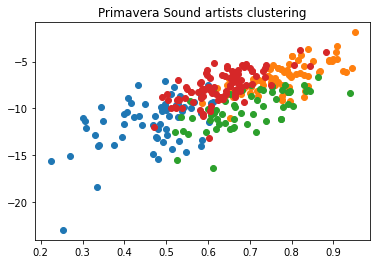

In [22]:
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    plt.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 2]) 
plt.title('Primavera Sound artists clustering')
plt.axis('on')
plt.show()

In [23]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0    64
1    83
2    62
3    98
dtype: int64

## Which is the best number of clusters?

In [24]:
kmeans.inertia_

1556.1476611974865

### Elbow

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

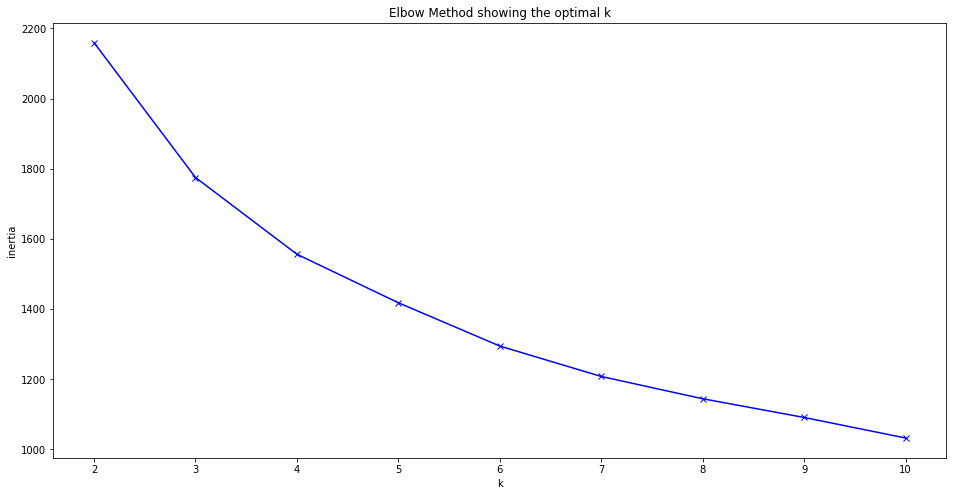

In [25]:
K = range(2, 11)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### Silouhette

- Checking K means from 2 to 20 and save it as pickle file on "kmeans" folder

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

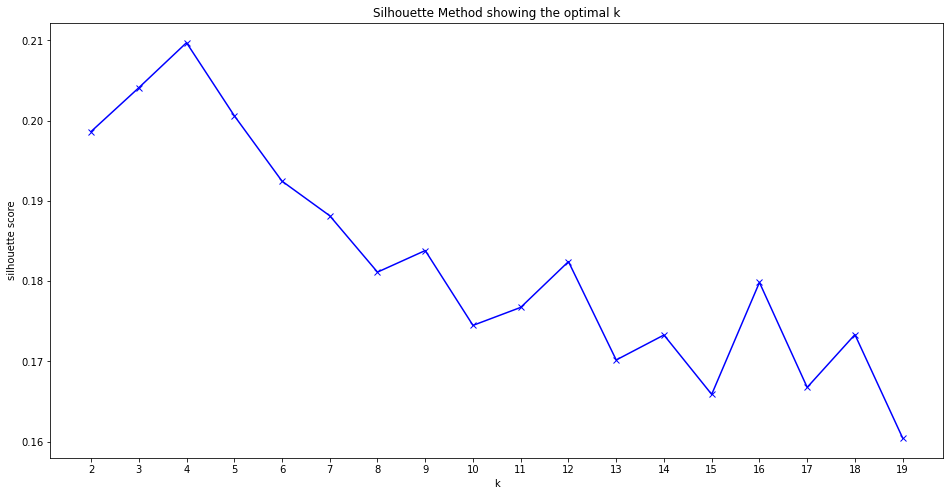

In [26]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans/kmeans_" + str(k) + ".pickle"    #SAVING ALL THE MODELS I TRY ON HARD DISK
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

<b> After checking elbow and Silouhette methods, I would say 4 clusters is the best number

## Inspecting the clusters

- Adding clusters also on X, the dataframe without scaling. Let's use groupby to use how looks every cluster

In [27]:
X["cluster"] =  clusters
X.groupby(['cluster']).mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.473897,0.463495,-11.515860,0.067051,0.475589,0.343314,0.173510,0.294885,116.734505
1,0.452393,0.769624,-6.802070,0.076741,0.112197,0.296505,0.227482,0.401511,129.629629
2,0.637771,0.694069,-10.009336,0.077510,0.160508,0.649586,0.164101,0.396164,127.695031
3,0.651777,0.632473,-7.691310,0.129418,0.265448,0.085509,0.200093,0.516292,118.787933


- Danceability, valence and speechiness increases with the cluster number.

- Cluster 2 and 3 similar but 3 has the highest instrumentalness (less vocals)

In [28]:
X_scaled_df["cluster"] = clusters
X_scaled_df = X_scaled_df.drop("cluster",axis=1)

In [29]:
X_scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
artist_id,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0.971547,-0.346482,0.379020,-0.051159,0.551486,-0.825840,-0.260473,0.580423,-0.432994
0cGUm45nv7Z6M6qdXYQGTX,0.026221,-0.349520,0.867126,1.643118,0.397050,-1.122004,-0.092950,0.330411,-0.794930
4F4pp8NUW08JuXwnoxglpN,1.300338,0.427476,1.029213,0.167491,-0.254766,-1.118909,-0.792385,0.815669,-1.212861
25uiPmTg16RbhZWAqwLBy5,0.352991,1.120684,1.588085,-0.024382,-0.921550,-1.037949,0.003844,0.768590,0.307984
04WGKyAt0klDPxUw2roFfi,-0.662191,-2.307410,-1.525973,-0.755500,0.533214,0.227804,-0.836097,-1.618924,-1.065719


In [30]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
artist_id,,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328,3
0cGUm45nv7Z6M6qdXYQGTX,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157,3
4F4pp8NUW08JuXwnoxglpN,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209,3
25uiPmTg16RbhZWAqwLBy5,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156,1
04WGKyAt0klDPxUw2roFfi,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417,0
...,...,...,...,...,...,...,...,...,...,...
6EVc5gJQXiUl586m1NFCNH,0.780667,0.662444,-11.950222,0.083521,0.068563,0.793911,0.119008,0.442465,126.962687,2
6GP540ZTiOPTz8uI76k43u,0.699966,0.595241,-6.241345,0.177755,0.131588,0.005671,0.120352,0.511069,124.609897,3
0osYTSrOpW6YESEC1lClwN,0.202000,0.479635,-15.387667,0.040883,0.718667,0.911167,0.092550,0.078617,115.269833,0


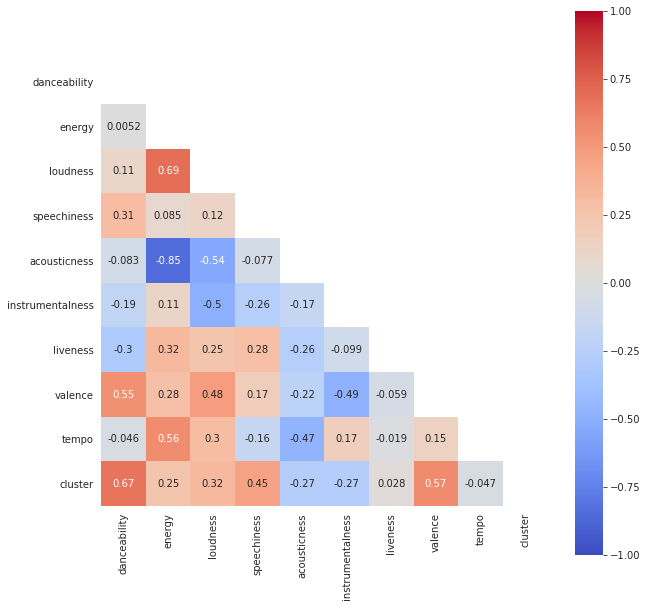

In [31]:
corr = X.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Saving with pickle

- Save the freshly trained standard scaler with pickle
- Save number of kmeans we think are the best one

In [32]:
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("kmeans/scaler.pickle", "wb") as f:  
    pickle.dump(scaler,f)

#with open("kmeans/kmeans_6.pickle", "wb") as f:    pickle.dump(kmeans,f)#

### How to load them

In [33]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

In [34]:
scaler2 = load("kmeans/scaler.pickle")
scaler2

StandardScaler()

In [35]:
kmeans4 = load("kmeans/kmeans_4.pickle")
kmeans4

KMeans(n_clusters=4, random_state=1234)

## Add cluster info the big dataframe

In [36]:
df_all = pd.read_csv('df_all.csv')
df_all =df_all.set_index('artist_id')

In [37]:
#X_scaled_df_clusters = X_scaled_df
df_all["cluster"] = clusters

In [38]:
df_all.head()

,Unnamed: 0,Artist,Hour,stage,date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
artist_id,,,,,,,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,0,Amaarae,18:45 - 19:30,Cupra FKA Seat,02.06.22,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328,3
0cGUm45nv7Z6M6qdXYQGTX,1,Kehlani,20:40 - 21:40,Cupra FKA Seat,02.06.22,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157,3
4F4pp8NUW08JuXwnoxglpN,2,Bad Gyal,23:20 - 00:20,Cupra FKA Seat,02.06.22,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209,3
25uiPmTg16RbhZWAqwLBy5,3,Charli XCX,02:00 - 03:00,Cupra FKA Seat,02.06.22,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156,1
04WGKyAt0klDPxUw2roFfi,4,Verde Prato,18:00 - 18:40,Pull & Bear,02.06.22,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417,0


In [39]:
df_all = df_all.drop('Unnamed: 0', axis=1)

# CLEAN & EXPAND DATA

## Some errors on ids index, replace it manually

In [40]:
df_all.rename(index={' 5n30EjOcjTVG11vtfNKbsd':'5n30EjOcjTVG11vtfNKbsd'},inplace=True)
df_all.rename(index={'4rjlerN21ygkIhmUv55irs ':'4rjlerN21ygkIhmUv55irs'},inplace=True)
df_all.rename(index={' 7qMC73hJTezS5KODuYn8ta':'7qMC73hJTezS5KODuYn8ta'},inplace=True)

In [41]:
all_ids = list(df_all.index.values)
all_ids

['21UPYSRWFKwtqvSAnFnSvS',
 '0cGUm45nv7Z6M6qdXYQGTX',
 '4F4pp8NUW08JuXwnoxglpN',
 '25uiPmTg16RbhZWAqwLBy5',
 '04WGKyAt0klDPxUw2roFfi',
 '70kkdajctXSbqSMJbQO424',
 '3inCNiUr4R6XQ3W43s9Aqi',
 '5INjqkS1o8h1imAzPqGZBb',
 '5szilpXHcwOqnyKLqGco5j',
 '13dTrWNNrnZ3AkgNyQNKP5',
 '2wJ4vsxWd7df7dRU4KcoDe',
 '5rLsN2LxYaEPLa1N7I2mPB',
 '1MIVXf74SZHmTIp4V4paH4',
 '4oLeXFyACqeem2VImYeBFe',
 '5CE2IfdYZEQGIDsfiRm8SI',
 '2BVE7Pqd8kxv9xEsuvoJoE',
 '5hAhrnb0Ch4ODwWu4tsbpi',
 '6PfSUFtkMVoDkx4MQkzOi3',
 '267VY6GX5LyU5c9M85ECZQ',
 '1QAJqy2dA3ihHBFIHRphZj',
 '7p7YeMEkvlFLwiNlm1Zt7C',
 '6QqLYrbjh5CnfMG7z5r96E',
 '3n8qeKQViV1waeCzZmS4Tx',
 '3uwAm6vQy7kWPS2bciKWx9',
 '2KEqzdPS7M5YwGmiuPTdr5',
 '7Hvq85OU8T7Hsd63zNBwaL',
 '5DZBnxCYzs32O2bbqK8KNg',
 '4skJp5OKvcc9eKokiuhi2s',
 '0mk9dVJMJF4fanFzeZo6K1',
 '0HutkALC7kq2L8b9bnZUkq',
 '35C0NSLogAwImm8HAMqEmG',
 '4V5obzWMr7BHZrjOiQwB4K',
 '6gyhsZUy2fzzWZBRVPmOw4',
 '0VeQgI9lzgoOMszAOq0iml',
 '1d3CepUS2V6F3cP9YWNfUO',
 '3Q2RrKEOBdkWI2MJQgdt84',
 '41BaIYCli96MF2wqqOutBR',
 

## Add genres

### Getting all the genres

In [42]:
info_all =[]

for i in all_ids:
    results = sp.artist(i)
    artist_id = results['genres']
    info_all.append(artist_id)

len(info_all)

307

In [43]:
df_all['genre'] = info_all
df_all

,Artist,Hour,stage,date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster,genre
artist_id,,,,,,,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,Amaarae,18:45 - 19:30,Cupra FKA Seat,02.06.22,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328,3,"[afro r&b, ghanaian alternative, ghanaian pop]"
0cGUm45nv7Z6M6qdXYQGTX,Kehlani,20:40 - 21:40,Cupra FKA Seat,02.06.22,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157,3,"[alternative r&b, dance pop, pop, pop rap, r&b]"
4F4pp8NUW08JuXwnoxglpN,Bad Gyal,23:20 - 00:20,Cupra FKA Seat,02.06.22,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209,3,"[neoperreo, rap catala, rap latina, trap catal..."
25uiPmTg16RbhZWAqwLBy5,Charli XCX,02:00 - 03:00,Cupra FKA Seat,02.06.22,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156,1,"[art pop, candy pop, dance pop, electropop, me..."
04WGKyAt0klDPxUw2roFfi,Verde Prato,18:00 - 18:40,Pull & Bear,02.06.22,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6EVc5gJQXiUl586m1NFCNH,Craig Richards,04:00 - 06:00,El Punto by adidas Originals (Primavera Bits),11.06.22,0.780667,0.662444,-11.950222,0.083521,0.068563,0.793911,0.119008,0.442465,126.962687,2,[tech house]
6GP540ZTiOPTz8uI76k43u,Paranoid 1966,01:30 - 02:15,Lotus (Primavera Bits),11.06.22,0.699966,0.595241,-6.241345,0.177755,0.131588,0.005671,0.120352,0.511069,124.609897,3,"[rap espanol, urbano espanol]"
0osYTSrOpW6YESEC1lClwN,Courtesy,02:40 - 03:55,Lotus (Primavera Bits),11.06.22,0.202000,0.479635,-15.387667,0.040883,0.718667,0.911167,0.092550,0.078617,115.269833,0,[hypertrance]


In [44]:
df_all['Artist'] = df_all['Artist'].astype(str)
df_all['Hour'] = df_all['Hour'].astype(str)
df_all['stage'] = df_all['stage'].astype(str)
df_all['date'] = df_all['date'].astype(str)

### Convert genre (list in each cell) to a new column on string format

In [45]:
df_all['genre_string'] = df_all['genre'].agg(lambda x: ','.join(map(str, x)))

In [46]:
df_all['genre_string']

artist_id
21UPYSRWFKwtqvSAnFnSvS           afro r&b,ghanaian alternative,ghanaian pop
0cGUm45nv7Z6M6qdXYQGTX            alternative r&b,dance pop,pop,pop rap,r&b
4F4pp8NUW08JuXwnoxglpN    neoperreo,rap catala,rap latina,trap catala,tr...
25uiPmTg16RbhZWAqwLBy5    art pop,candy pop,dance pop,electropop,metropo...
04WGKyAt0klDPxUw2roFfi                                                     
                                                ...                        
6EVc5gJQXiUl586m1NFCNH                                           tech house
6GP540ZTiOPTz8uI76k43u                           rap espanol,urbano espanol
0osYTSrOpW6YESEC1lClwN                                          hypertrance
5igyz9vWH6ban6NMfKeCir                   atmospheric dnb,experimental house
2SYqJ3uDLLXZNyZdLKBy4M    atmospheric dnb,big beat,drum and bass,drumfun...
Name: genre_string, Length: 307, dtype: object

### Replace missing values, check it manually (looking on websites)

In [47]:
df_all.iloc[13, 15] = 'electronic'
df_all.iloc[20, 15] = 'electronic'
df_all.iloc[22, 15] = 'rock'
df_all.iloc[39,15] = 'beats house,funk,soul,disco'
df_all.iloc[40,15] = 'dancehall,melodic techno,afrofuturism'
df_all.iloc[44,15] = 'indie pop,catalan indie'
df_all.iloc[51,15] = 'house,r&b'
df_all.iloc[52,15] = 'soul,funk,house,tropical sounds,detroit house'
df_all.iloc[53,15] = 'post-rock'
df_all.iloc[58,15] = 'experimental,avant-garde'
df_all.iloc[64,15] = 'rock'
df_all.iloc[80,15] = 'pop'
df_all.iloc[85,15] = 'indie, alternative pop-rock'
df_all.iloc[87,15] = 'r&b,tropical house'
df_all.iloc[97,15] = 'techno'
df_all.iloc[98,15] = 'house'
df_all.iloc[99,15] = 'techno'
df_all.iloc[101,15] = 'techno'
df_all.iloc[105,15] = 'genre not defined'
df_all.iloc[107,15] = 'hip hop'
df_all.iloc[134,15] = 'pop-rock,power-pop'
df_all.iloc[141,15] = 'industrial'
df_all.iloc[144,15] = 'ambient'
df_all.iloc[146,15] = 'genre not defined'
df_all.iloc[150,15] = 'reggaeton'
df_all.iloc[154,15] = 'techno'
df_all.iloc[188,15] = 'folk,catalan folk'
df_all.iloc[194,15] = 'rural trap, euskal trap'
df_all.iloc[195,15] = 'hip hop'
df_all.iloc[204,15] = 'soul,hip hop,house,afro,latin,electronica,jazz'
df_all.iloc[209,15] = 'pop'
df_all.iloc[227,15] = 'post-punk'
df_all.iloc[232,15] = 'genre not defined'
df_all.iloc[238,15] = 'contemporanean jazz,afrocuban'
df_all.iloc[281,15] = 'techno'
df_all.iloc[282,15] = 'folk pop,catalan indie'
df_all.iloc[295,15] = 'footwork, jungle'
df_all.iloc[296,15] = 'pop'
df_all.iloc[300,15] = 'hip hop,dub'

### Inspect genres

In [48]:
df_all['genre_string'].unique()

array(['afro r&b,ghanaian alternative,ghanaian pop',
       'alternative r&b,dance pop,pop,pop rap,r&b',
       'neoperreo,rap catala,rap latina,trap catala,trap latino,urbano espanol',
       'art pop,candy pop,dance pop,electropop,metropopolis,pop,uk pop',
       '', 'contemporary country,country dawn,pop,texas country',
       'alternative rock,anti-folk,art rock,dream pop,indie pop,indie rock,lo-fi,modern rock,new wave,rock',
       'australian psych,neo-psychedelic',
       'art pop,atlanta indie,indie pop', 'riot grrrl',
       'art pop,chamber pop,dream pop,indie folk,indie pop,indie rock,melancholia,new jersey indie,stomp and holler',
       'argentine alternative rock,argentine indie,argentine indie rock,argentine rock,indie platense,latin rock,rock en espanol,rock nacional',
       'dance pop,edm,pop,pop dance,post-teen pop,tropical house,uk pop',
       'electronic',
       'alternative hip hop,big beat,downtempo,electronica,hip hop,nu jazz,trip hop,turntablism',
       'lat

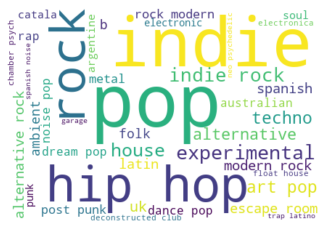

<Figure size 1080x720 with 0 Axes>

In [49]:
from wordcloud import WordCloud
allWords = ' '.join( [i for i in df_all['genre_string']])
wordCloud = WordCloud(width = 430, height = 300, random_state = 21, max_font_size = 100, background_color="white", max_words = 40).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.figure(figsize=(15,10))

plt.savefig('genres.jpg')

In [50]:
len(df_all[df_all['genre_string'].str.contains('pop')])

112

In [51]:
len(df_all[df_all['genre_string'].str.contains('indie')])

96

In [52]:
len(df_all[df_all['genre_string'].str.contains('rock')])

68

In [53]:
len(df_all[df_all['genre_string'].str.contains('hip hop')])

27

In [54]:
df_all.head()

,Artist,Hour,stage,date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster,genre,genre_string
artist_id,,,,,,,,,,,,,,,,
21UPYSRWFKwtqvSAnFnSvS,Amaarae,18:45 - 19:30,Cupra FKA Seat,02.06.22,0.678333,0.599000,-7.700191,0.089061,0.342079,0.088620,0.180644,0.492207,119.078328,3,"[afro r&b, ghanaian alternative, ghanaian pop]","afro r&b,ghanaian alternative,ghanaian pop"
0cGUm45nv7Z6M6qdXYQGTX,Kehlani,20:40 - 21:40,Cupra FKA Seat,02.06.22,0.561209,0.598581,-6.391597,0.176166,0.315350,0.009152,0.189676,0.458883,115.725157,3,"[alternative r&b, dance pop, pop, pop rap, r&b]","alternative r&b,dance pop,pop,pop rap,r&b"
4F4pp8NUW08JuXwnoxglpN,Bad Gyal,23:20 - 00:20,Cupra FKA Seat,02.06.22,0.719070,0.705698,-5.957047,0.100302,0.202536,0.009982,0.151965,0.523563,111.853209,3,"[neoperreo, rap catala, rap latina, trap catal...","neoperreo,rap catala,rap latina,trap catala,tr..."
25uiPmTg16RbhZWAqwLBy5,Charli XCX,02:00 - 03:00,Cupra FKA Seat,02.06.22,0.601695,0.801263,-4.458728,0.090438,0.087132,0.031706,0.194895,0.517288,125.943156,1,"[art pop, candy pop, dance pop, electropop, me...","art pop,candy pop,dance pop,electropop,metropo..."
04WGKyAt0klDPxUw2roFfi,Verde Prato,18:00 - 18:40,Pull & Bear,02.06.22,0.475917,0.328667,-12.807417,0.052850,0.338917,0.371342,0.149608,0.199058,113.216417,0,[],


In [55]:
df_all.dtypes

Artist               object
Hour                 object
stage                object
date                 object
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
cluster               int32
genre                object
genre_string         object
dtype: object

## Add new column with part of the day

 -To later sort the concerts based on time, we will also need to know what part of the day it is (afternoon, morning...) If we sort only by time, first the 1am concerts would appear. So, filter first by part of the day and then by time

In [56]:
df_all['Hour']

artist_id
21UPYSRWFKwtqvSAnFnSvS    18:45 - 19:30
0cGUm45nv7Z6M6qdXYQGTX    20:40 - 21:40
4F4pp8NUW08JuXwnoxglpN    23:20 - 00:20
25uiPmTg16RbhZWAqwLBy5    02:00 - 03:00
04WGKyAt0klDPxUw2roFfi    18:00 - 18:40
                              ...      
6EVc5gJQXiUl586m1NFCNH    04:00 - 06:00
6GP540ZTiOPTz8uI76k43u    01:30 - 02:15
0osYTSrOpW6YESEC1lClwN    02:40 - 03:55
5igyz9vWH6ban6NMfKeCir    04:15 - 05:40
2SYqJ3uDLLXZNyZdLKBy4M    16:30 - 18:00
Name: Hour, Length: 307, dtype: object

- Creating two new columns, spliting hours

In [57]:
df_all[['start_hour', 'end_hour']] = df_all['Hour'].str.split('-', expand=True)

In [58]:
df_all.loc[df_all['start_hour'].str.contains("14:"),'part_day'] = 'afternoon'
df_all.loc[df_all['start_hour'].str.contains("15:"),'part_day'] = 'afternoon'
df_all.loc[df_all['start_hour'].str.contains("16:"),'part_day'] = 'afternoon'
df_all.loc[df_all['start_hour'].str.contains("17:"),'part_day'] = 'afternoon'
df_all.loc[df_all['start_hour'].str.contains("18:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("19:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("20:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("21:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("22:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("23:"),'part_day'] = 'evening'
df_all.loc[df_all['start_hour'].str.contains("00:"),'part_day'] = 'night'
df_all.loc[df_all['start_hour'].str.contains("01:"),'part_day'] = 'night'
df_all.loc[df_all['start_hour'].str.contains("02:"),'part_day'] = 'night'
df_all.loc[df_all['start_hour'].str.contains("03:"),'part_day'] = 'night'
df_all.loc[df_all['start_hour'].str.contains("04:"),'part_day'] = 'night'
df_all.loc[df_all['start_hour'].str.contains("05:"),'part_day'] = 'night'

In [59]:
df_all['part_day'].unique()

array(['evening', 'night', 'afternoon'], dtype=object)

## Change format of artists names
- Write each first letter of the artist in capital letters.

In [60]:
df_all['Artist'] = df_all['Artist'].str.title()

In [61]:
df_all['Artist'].unique()

array(['Amaarae', 'Kehlani', 'Bad Gyal', 'Charli Xcx', 'Verde Prato',
       'Kacey Musgraves', 'Pavement', 'Tame Impala', 'Faye Webster',
       'The Linda Lindas', 'Sharon Van Etten',
       'El Mato A Un Policia Motorizado', 'Mabel', 'Fred Again..',
       'Dj Shadow', 'Carolina Durante', 'Yo La Tengo', '100 Gecs',
       'Dinosaur Jr.', 'Cigarettes After Sex', 'Carla', 'Gustaf',
       'Kim Gordon', 'Girl In Red', 'Rina Sawayama', 'Black Midi',
       'Les Savy Fav', 'Pond', 'Aiko El Groupo', 'Otoboke Beaver',
       'Black Lips', 'The Armed', 'Soto Asa', 'Richard Dawson',
       'Rodrigo Cuevas', 'Lingua Ignota', 'Maria Del Mar Bonet', 'Neska',
       'Afrodeutsche', 'Ivy Barkakati', 'Crystallmess', 'Call Super',
       'Honey Dijon', 'D. Tiffany', 'Rombo', 'Pelada', 'Oklou',
       'Osheyack', 'Hannah Diamond', 'Big Freedia', 'Shygirl',
       'Kareem Ali', 'Carista', 'Moin', 'Amaia', 'Beck', 'The Strokes',
       'Caribou', 'Marina Herlop', 'Parquet Courts', 'The National',
    

# RECOMMENDATIONS

## Input: artist (anyone, it doesn't have to be in the line up). Output: song of similar Artist on festival

- Give me a song of an artist similar to my input (using API). 
- Problem: it shows first artist who find with this name. How to improve: check if the ID is correct
- Can take almost a minute

In [62]:
def concert_recommenderTEST_song(artist):
    results = sp.search(artist,limit=1,market="GB")
    artist_id = results['tracks']['items'][0]['album']['artists'][0]['id']  

    info =[]
    r = requests.get(BASE_URL + 'artists/' + artist_id , 
                 headers=headers)
    d = r.json()
    info.append(d)
    time.sleep(0.5)

    albums=[]
    r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers)
    f = r.json()
    albums.append(f)
    time.sleep(0.5)

    it=[]
    for i in albums:
        a = i['items']
        it.append(a)
    
    data = []
    for i in it:
        for album in i:
            album_name = album['name']
    
            # pull all tracks from this album
            r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
            headers=headers)
            tracks = r.json()['items']
    
            for track in tracks:
            # get audio features (key, liveness, danceability, ...)
                f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
                    headers=headers)
                f = f.json()
        
                data.append(f)
    df = pd.DataFrame(data)
    df.drop(['key', 'track_href','mode','type','uri','duration_ms','analysis_url','time_signature','id'], axis = 1, inplace = True) 
    df = df.mean().to_frame().T
    df_scaled = scaler.transform(df)
    cluster_number = kmeans4.predict(df_scaled)[0]   #which cluster number
    recom = df_all[df_all.cluster== cluster_number]
    index_list = recom.index.values.tolist()
    artist_id_recom = random.choice(index_list)  #this is an id
    df_all.loc[[artist_id_recom]]         #give me the row with this id
    recom_name = str(df_all.loc[[artist_id_recom]]['Artist'][0])
    
    song_recom = sp.artist_top_tracks(artist_id_recom, country='US')  #top ten tracks recommended artist
    song_recom_id = song_recom['tracks'][0]['id']   #id   #best song id recommended artist
    #random = recom.sample()    #choice a random row on the filtered recomendations
    #print (random)
    #df_all.loc[[artist_id]]
    #df_all.loc[[artist_id]]['Artist']
    #recommendation = df_all.loc[[artist_id]]['Artist']    return random['Artist']

    #return recommendation
    print ('My recommendation is: ' +'\033[1m'+ str(df_all.loc[[artist_id_recom]]['Artist'][0]))
    print('\033[0m'+ 'Genres: ' + str(df_all.loc[[artist_id_recom]]['genre'][0])) #string
    print()
    print('When: ' + str(df_all.loc[[artist_id_recom]]['date'][0]))
    print('Time: ' + str(df_all.loc[[artist_id_recom]]['Hour'][0]))
    print('Stage: ' + str(df_all.loc[[artist_id_recom]]['stage'][0]))
    print()
    print('This is the most popular song of ' + recom_name + ':')
    return IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
    

In [63]:
concert_recommenderTEST_song('queen')

My recommendation is: Chaqueta De Chandal
Genres: ['spanish noise pop']

When: 03.06.22
Time: 19:25 - 20:10
Stage: Pitchfork

This is the most popular song of Chaqueta De Chandal:


## Which day do you want to go?

- Improvementes to do:
    - don't only accept Y/N, also Yes/No, etc...
    - Error if: date ok -- artist bad (error)
    

In [64]:
def recom_from_date():
    days_list = ['02.06.22', '03.06.22', '04.06.22', '09.06.22', '10.06.22', '11.06.22']
    artist_list = df_all['Artist'].tolist()
    possibilities = artist_list
    n = 1   
    cutoff = 0.7
    day = input('Which day do you want to go to the festival? \n(02.06.22 / 03.06.22 / 04.06.22 / 09.06.22 / 10.06.22 / 11.06.22): ')
    
    if day not in days_list: #bad date
        day = input('Please insert a date in the valid date format: ')
        if day not in days_list: #bad date, bad date
            print('Sorry, this date is not in a valid format.')
        else: # 1bad date, 2 good date         
            artist = input('Enter an artist/band you like from the line-up: ').title()

            if artist not in artist_list:  #bad date, good date, bad artist
                close_matches_artist = difflib.get_close_matches(artist, 
                        possibilities, n, cutoff)
                if len(close_matches_artist) > 0:     # We have found similarities
                    answer = input('Do you mean ' + close_matches_artist[0] + '? (Y/N)').title()  #funciona
                    if answer == 'Y':
                        print('---')
                        input_id = df_all.index[df_all['Artist']==close_matches_artist[0]][0]
                        song_recom = sp.artist_top_tracks(input_id, country='US')  #top ten tracks recommended artist
                        song_recom_id = song_recom['tracks'][0]['id']
                        display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                        width="320",
                        height="80",
                        frameborder="0",
                        allowtransparency="true",
                        allow="encrypted-media"))
                        #search for the cluster number of this artist in the dataframe with all the info
                        
                        cluster_number = df_all[df_all['Artist'] == close_matches_artist[0]]['cluster'][0]
                        recom = df_all[df_all.cluster== cluster_number]
                        #filter recommendations by date
                        df_recom = recom[recom['date'] == day]
                        df_recom['artist_id'] = df_recom.index
                        df_recom.reset_index(drop=True, inplace= True)
                        df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
                        df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
                        #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
                        print('If you like '+ '\033[1m' + close_matches_artist[0] + '\033[0m' + ', you might like these artists/bands playing on ' + day)
                        print()
                        for i in range(0,len(df_recom_sorted)):
                            print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
                            print()
                            print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
                            print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
                            print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
                            print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
                            #print (df_recom_sorted.iloc[i]['artist_id'])
                            artist_id = df_recom_sorted.iloc[i]['artist_id']
                            song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
                            song_recom_id = song_recom['tracks'][0]['id']
                            display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                                width="320",
                                height="80",
                                frameborder="0",
                                allowtransparency="true",
                                allow="encrypted-media"))
                               
                            print('---')
                
                
                    else:
                        print("Sorry, I don't know this artist")
                else:
                    print("Sorry, I don't know this artist")
                    
            else:   #1 fecha mal, 2 bien, artist bien
                input_id = df_all.index[df_all['Artist']==artist][0]
                song_recom = sp.artist_top_tracks(input_id, country='US')  #top ten tracks recommended artist
                song_recom_id = song_recom['tracks'][0]['id']
                display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                width="320",
                height="80",
                frameborder="0",
                allowtransparency="true",
                allow="encrypted-media"))
                
                cluster_number = df_all[df_all['Artist'] == artist]['cluster'][0]
                recom = df_all[df_all.cluster== cluster_number]
                #filter recommendations by date
                df_recom = recom[recom['date'] == day]
                df_recom['artist_id'] = df_recom.index
                df_recom.reset_index(drop=True, inplace= True)
                df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
                df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
                #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
                print('If you like '+  artist + ' you might like these artists/bands also playing on ' + day)
                print()
                for i in range(0,len(df_recom_sorted)):
                    print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
                    print()
                    print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
                    print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
                    print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
                    print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
                    #print (df_recom_sorted.iloc[i]['artist_id'])
                    artist_id = df_recom_sorted.iloc[i]['artist_id']
                    song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
                    song_recom_id = song_recom['tracks'][0]['id']
                    display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                            width="320",
                            height="80",
                            frameborder="0",
                            allowtransparency="true",
                            allow="encrypted-media"))
                               
                print('---')

    else:   #correct date
        print('---')   #SHOW ARTIST INPUT, NOT WORKING
        input_artist = input('Enter an artist/band you like: ').title()
        if input_artist not in artist_list:
            close_matches_artist = difflib.get_close_matches(input_artist, 
                    possibilities, n, cutoff)
            if len(close_matches_artist) > 0:     # We have found similarities
                answer = input('Do you mean ' + close_matches_artist[0] + '? (Y/N) ').title()  #funciona
                if answer == 'Y':
                    print('---')
                    #search for the cluster number of this artist in the dataframe with all the info
                    cluster_number = df_all[df_all['Artist'] == close_matches_artist[0]]['cluster'][0]
                    recom = df_all[df_all.cluster== cluster_number]
                    #filter recommendations by date
                    df_recom = recom[recom['date'] == day]
                    df_recom['artist_id'] = df_recom.index
                    df_recom.reset_index(drop=True, inplace= True)
                    df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
                    df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
                    #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
                    print('If you like '+ close_matches_artist[0] + ', you might like these artists/bands also playing on ' + day)
                    print()
                    for i in range(0,len(df_recom_sorted)):
                        print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
                        print()
                        print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
                        print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
                        print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
                        print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
                        #print (df_recom_sorted.iloc[i]['artist_id'])
                        artist_id = df_recom_sorted.iloc[i]['artist_id']
                        song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
                        song_recom_id = song_recom['tracks'][0]['id']
                        display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                            width="320",
                            height="80",
                            frameborder="0",
                            allowtransparency="true",
                            allow="encrypted-media"))
            

        
        else: #correct date, correct artist
            
            input_id = df_all.index[df_all['Artist']==input_artist][0]
            song_recom = sp.artist_top_tracks(input_id, country='US')  #top ten tracks recommended artist
            song_recom_id = song_recom['tracks'][0]['id']
            display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                width="320",
                height="80",
                frameborder="0",
                allowtransparency="true",
                allow="encrypted-media"))
        
            #search for the cluster number of this artist in the dataframe with all the info
            cluster_number = df_all[df_all['Artist'] == input_artist]['cluster'][0]
            recom = df_all[df_all.cluster== cluster_number]
            #filter recommendations by date
            df_recom = recom[recom['date'] == day]
            df_recom['artist_id'] = df_recom.index
            df_recom.reset_index(drop=True, inplace= True)
            df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
            df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
            #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
            print('If you like '+ input_artist + ', you might like these artists/bands also playing on ' + day)
            print()
            for i in range(0,len(df_recom_sorted)):
                print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
                print()
                print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
                print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
                print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
                print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
                #print (df_recom_sorted.iloc[i]['artist_id'])
                artist_id = df_recom_sorted.iloc[i]['artist_id']
                song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
                song_recom_id = song_recom['tracks'][0]['id']
                display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                    width="320",
                    height="80",
                    frameborder="0",
                    allowtransparency="true",
                    allow="encrypted-media"))
                print('---')

### Function

In [ ]:
recom_from_date()

## Which concert do you not want to miss?

In [ ]:
def recom_from_artist():
    artist = input('Enter an artist/band you like: ').title()
    artist_list = df_all['Artist'].tolist()
    
    possibilities = artist_list
    n = 1   
    cutoff = 0.7
    
    if artist not in artist_list:
        close_matches_artist = difflib.get_close_matches(artist, possibilities, n, cutoff)
        
        if len(close_matches_artist) > 0:     # We have found similarities
            answer = input('Do you mean ' + close_matches_artist[0] + '? (Y/N) 
                           ').title()
            
            if answer == 'Y':
                print('---')
                artist_concert = df_all[df_all['Artist'] == close_matches_artist[0]]['date'][0]
                print(close_matches_artist[0] +' is playing on ' + artist_concert)
                preference_id = df_all.index[df_all['Artist']==close_matches_artist[0]][0]
                song_recom = sp.artist_top_tracks(preference_id, country='US')  #top ten tracks recommended artist
                song_recom_id = song_recom['tracks'][0]['id']
                display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                width="320",
                height="80",
                frameborder="0",
                allowtransparency="true",
                allow="encrypted-media"))
    
                print('If you like ' + close_matches_artist[0] +', you might also like these bands performing on the same day.')
                print()
                print('-- ITINERARY --')
                cluster_number = df_all[df_all['Artist'] == close_matches_artist[0]]['cluster'][0]
                recom = df_all[df_all.cluster== cluster_number]
                #filter recommendations by date
                df_recom = recom[recom['date'] == artist_concert]
                df_recom['artist_id'] = df_recom.index
                df_recom.reset_index(drop=True, inplace= True)
                df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
                df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
                df_recom_sorted = df_recom_sorted.drop(df_recom_sorted[df_recom_sorted['Artist'] == close_matches_artist[0]].index)
                #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
                print()
                for i in range(0,len(df_recom_sorted)):
                    print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
                    print()
                    print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
                    print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
                    print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
                    print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
                    #print (df_recom_sorted.iloc[i]['artist_id'])
                    artist_id = df_recom_sorted.iloc[i]['artist_id']
                    song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
                    song_recom_id = song_recom['tracks'][0]['id']
                    display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                        width="320",
                        height="80",
                        frameborder="0",
                        allowtransparency="true",
                        allow="encrypted-media"))
                print('Have fun!')
                    
            else:
                print("Sorry, try with another artist")
                    
        else:   #NO COINCIDENCES
            print("Sorry, I don't know this artist")
        
    else: 
        #artist = input('I can not find ' + artist + ' on the line-up, please write another one: ').title()
        artist_concert = df_all[df_all['Artist'] == artist]['date'][0]
        print(artist +' is playing on ' + artist_concert)
        preference_id = df_all.index[df_all['Artist']==artist][0]
        song_recom = sp.artist_top_tracks(preference_id, country='US')  #top ten tracks recommended artist
        song_recom_id = song_recom['tracks'][0]['id']
        display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
            width="320",
            height="80",
            frameborder="0",
            allowtransparency="true",
            allow="encrypted-media"))
    
        print('If you like ' + artist +', you might also like these bands performing on the same day.')
        print()
        print('-- ITINERARY --')
        cluster_number = df_all[df_all['Artist'] == artist]['cluster'][0]
        recom = df_all[df_all.cluster== cluster_number]
        #filter recommendations by date
        df_recom = recom[recom['date'] == artist_concert]
        df_recom['artist_id'] = df_recom.index
        df_recom.reset_index(drop=True, inplace= True)
        df_recom_clean =  df_recom.loc[:, ["Artist", "Hour", "stage", "genre_string","part_day", "artist_id"]]
        df_recom_sorted = df_recom_clean.sort_values(['part_day', 'Hour'], ascending=[True, True])
        df_recom_sorted = df_recom_sorted.drop(df_recom_sorted[df_recom_sorted['Artist'] == artist].index)
        #print(' This day are ' + str(len(df_recom_sorted)) + ' artists/bands similars to ' + artist)
        print()
        for i in range(0,len(df_recom_sorted)):
            print ('\033[1m' + df_recom_sorted.iloc[i]['Artist'])
            print()
            print ('\033[0m' +'When? ' + df_recom_sorted.iloc[i]['Hour'])
            print ('On which stage? ' + df_recom_sorted.iloc[i]['stage'])
            print ('Genre: ' + df_recom_sorted.iloc[i]['genre_string'])
            print ('This is the most popular song of '+ df_recom_sorted.iloc[i]['Artist'])
            #print (df_recom_sorted.iloc[i]['artist_id'])
            artist_id = df_recom_sorted.iloc[i]['artist_id']
            song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
            song_recom_id = song_recom['tracks'][0]['id']
            display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
                width="320",
                height="80",
                frameborder="0",
                allowtransparency="true",
                allow="encrypted-media"))
            print('---')
        print('Have fun!')     
    

### Function

In [ ]:
recom_from_artist()

## Top track of artist on line-up

In [ ]:
def popular_song(artist):
    artist_id = df_all.index[df_all['Artist']==artist][0]
    song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
    song_recom_id = song_recom['tracks'][0]['id']
    display(IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
            width="320",
            height="80",
            frameborder="0",
            allowtransparency="true",
            allow="encrypted-media"))

## Other insights

### Which is the group with the most danceability performing today?

In [ ]:
new_df = df_all[df_all['date'] == '02.06.22'].sort_values(by='danceability', ascending=False)
name = new_df.iloc[0]
name

In [ ]:
artist_id ='6gyhsZUy2fzzWZBRVPmOw4'

In [ ]:
song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
song_recom_id = song_recom['tracks'][0]['id'] 

In [ ]:
 IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

### Which is the group with the most energy performing today?## Cual es el grupo mas energy de hoy?

In [ ]:
new_df = df_all[df_all['date'] == '02.06.22'].sort_values(by='energy', ascending=False)
name = new_df.iloc[0]
name

In [ ]:
artist_id ='0HutkALC7kq2L8b9bnZUkq'

In [ ]:
song_recom = sp.artist_top_tracks(artist_id, country='US')  #top ten tracks recommended artist
song_recom_id = song_recom['tracks'][0]['id'] 

In [ ]:
 IFrame(src="https://open.spotify.com/embed/track/"+song_recom_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [ ]:
df_test = df_all.iloc[10:15]
df_test